In [216]:
import cv2
import mywarper
from PIL import Image
import numpy as np
from skimage import color
import os
import matplotlib.pyplot as plt
from numpy import linalg
import scipy.io as sio
import math

In [2]:
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
######PCA Part 1#############

In [24]:
folder = 'images'
dataset = np.ndarray(shape=(1000, 128, 128), dtype = np.float32)

In [41]:
#Read files and extract V channel from hsv image
filenames = []

for _file in os.listdir(folder):
    filenames.append(_file)

for i in range(len(filenames)):
    img = Image.open(folder + "/" + filenames[i])
    hsv_img = color.rgb2hsv(img)
    if i in range(800,810):
        print filenames[i]
    dataset[i] = hsv_img[:, :, 2]

000882.jpg
000883.jpg
000884.jpg
000885.jpg
000886.jpg
000887.jpg
000889.jpg
000890.jpg
000891.jpg
000892.jpg


In [42]:
#Split dataset into train and test: first 800 in train and last 200 in test
X_train = dataset[0:800, :, :]
X_test = dataset[800:, :, :]

In [43]:
#Compute the mean of training data and center all the images to it
mean_img = np.mean(X_train, axis = 0)

X_train_wo_mean = np.zeros((np.shape(X_train)))
for i in range(len(X_train)):
    X_train_wo_mean[i] = X_train[i] - mean_img
    
X_test_wo_mean = np.zeros((np.shape(X_test)))
for i in range(len(X_test)):
    X_test_wo_mean[i] = X_test[i] - mean_img    

In [44]:
#Find the covariance matrix of X_train
X_train_reshaped = X_train_wo_mean.reshape(800, 128*128) # each observation / image becomes a row and there are 800 such rows
cov_matrix = np.cov(X_train_reshaped.T)
np.shape(cov_matrix)

(16384L, 16384L)

In [46]:
U, S, V = np.linalg.svd(cov_matrix)

In [48]:
#Slice the first 50 eigen vectors and find the projections of the training images on the eigen vectors
eigen_vectors_50 = U[:, 0:50]
X_test_reshaped = X_test_wo_mean.reshape(200, 128*128).T
X_test_reduced = np.dot(eigen_vectors_50.T, X_test_reshaped)

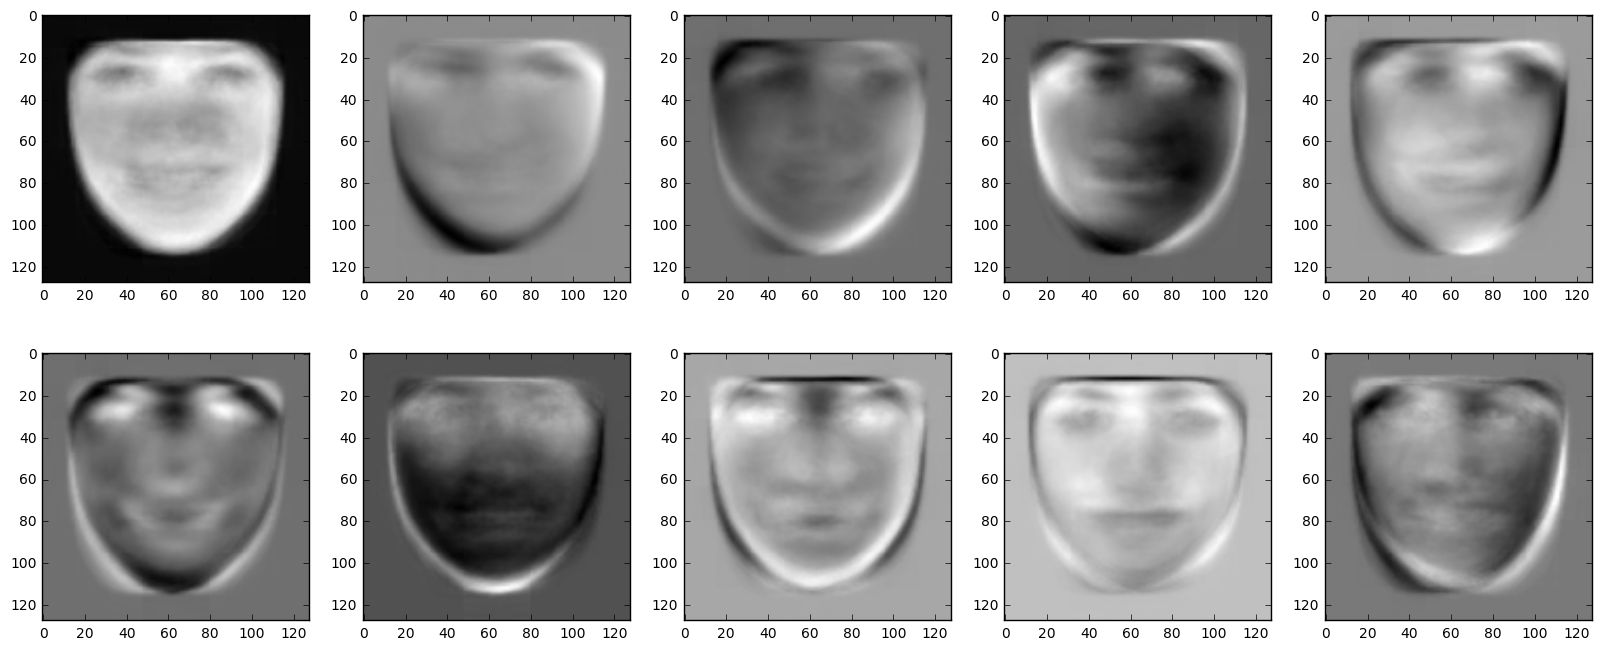

In [60]:
###########Part i####### Print the first 10 eigen faces #####################
fig, axs = plt.subplots(2, 5, figsize=(20, 8), squeeze=False)
for i in range(5):
    axs[0][i].imshow(eigen_vectors_50[:, i].reshape(128, 128), cmap = "gray")
    axs[1][i].imshow(eigen_vectors_50[:, i + 5].reshape(128, 128), cmap = "gray")
plt.show()

In [61]:
#Reconstruct image using the projections and eigen vectors and add mean to re-position the images
X_test_reconst = np.dot(eigen_vectors_50, X_test_reduced)
X_test_reconst_with_mean = np.zeros((200, 128, 128))
for i in range(200):
    X_test_reconst_with_mean[i] = X_test_reconst[:, i:i+1].reshape(128, 128) + mean_img

In [73]:
#Use original H & S channel along with reconstructed V channel to reconstruct image

original_images = np.zeros((10, 128, 128, 3))
reconst_images = np.zeros((10, 128, 128, 3))

for i in range(10):
    original_images[i] = Image.open(folder + "/" + filenames[i + 800])
    hsv_img = color.rgb2hsv(original_images[i])
    hsv_img[:, :, 2] = X_test_reconst_with_mean[i]
    #hsv_img_reconst = hsv_img[:, :, 0]
    #hsv_img_reconst = np.dstack((hsv_img_reconst,hsv_img[:, :, 1]))
    #hsv_img_reconst = np.dstack((hsv_img_reconst, X_test_reconst_with_mean[i]))
    
    reconst_images[i] = color.hsv2rgb(hsv_img)
    #plt.imshow(np.clip(img, 0, 1))
    #plt.show()

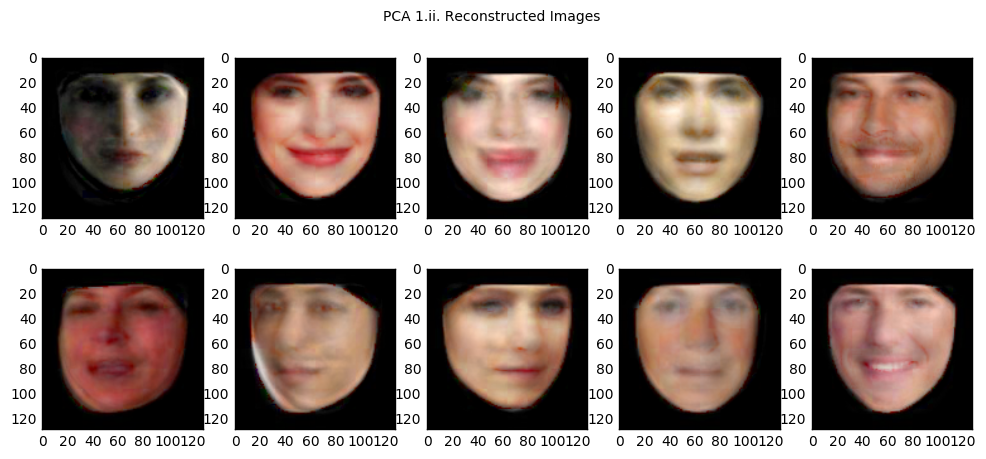

In [82]:
#Display 10 Reconstructed images
f, a = plt.subplots(2, 5, figsize=(12, 5), squeeze = False)
for i in range(5):
    a[0][i].imshow(np.clip(reconst_images[i], 0, 1))
    a[1][i].imshow(np.clip(reconst_images[i + 5], 0, 1))
f.suptitle('PCA 1.ii. Reconstructed Images')
plt.show()

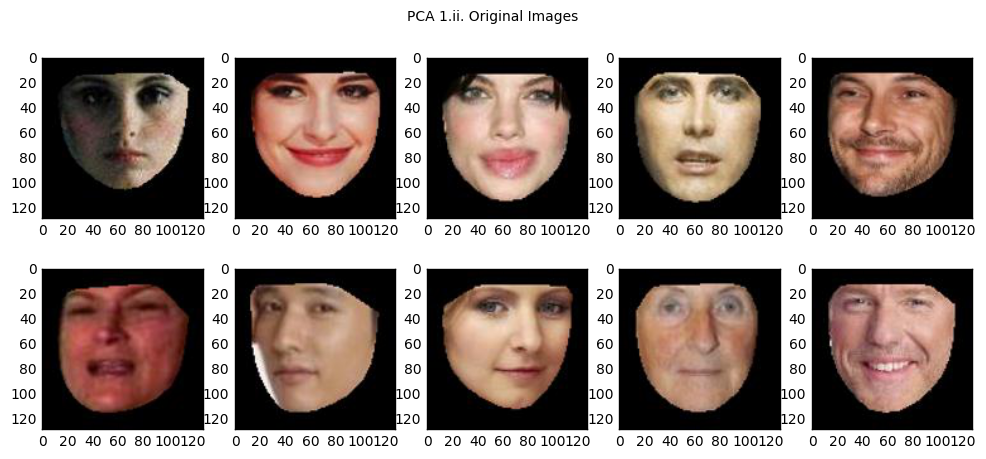

In [86]:
#Display 10 Original images
f, a = plt.subplots(2, 5, figsize=(12, 5), squeeze = False)
for i in range(5):
    a[0][i].imshow(Image.open(folder + "/" + filenames[i + 800]))
    a[1][i].imshow(Image.open(folder + "/" + filenames[i + 805]))
f.suptitle('PCA 1.ii. Original Images')
plt.show()

In [91]:
#Find the reconstruction error rate for k = 1, 5, 10, 15, .... 50
reconst_error = np.zeros((11))

j = 1
for k in range(5, 51, 5):
    k_eigen_vectors = np.ndarray(shape=(16384, k))
    k_eigen_vectors = U[:, 0:k]
    X_test_reduced = np.dot(k_eigen_vectors.T, X_test_reshaped)
    X_test_reconst = np.dot(k_eigen_vectors, X_test_reduced)
    X_test_reconst_with_mean = np.zeros((200, 128, 128))
    for i in range(200):
        X_test_reconst_with_mean[i] = X_test_reconst[:, i:i+1].reshape(128, 128) + mean_img
    sum_of_sq_error = 0
    for i in range(200):
        img = Image.open(folder + "/" + filenames[i + 800])
        hsv_img = color.rgb2hsv(img)
        sum_of_sq_error += np.sum((X_test_reconst_with_mean[i] - hsv_img[:, :, 2]) ** 2)
    reconst_error[j] =  sum_of_sq_error / (200 * 128 * 128)
    j+=1

k_eigen_vectors = np.ndarray(shape=(16384, 1))
k_eigen_vectors = U[:, 0:1]
X_test_reduced = np.dot(k_eigen_vectors.T, X_test_reshaped)
X_test_reconst = np.dot(k_eigen_vectors, X_test_reduced)
X_test_reconst_with_mean = np.zeros((200, 128, 128))
for i in range(200):
    X_test_reconst_with_mean[i] = X_test_reconst[:, i:i+1].reshape(128, 128) + mean_img
sum_of_sq_error = 0
for i in range(200):
    img = Image.open(folder + "/" + filenames[i + 800])
    hsv_img = color.rgb2hsv(img)
    sum_of_sq_error += np.sum((X_test_reconst_with_mean[i] - hsv_img[:, :, 2]) ** 2)
#sum_of_sq_error =
reconst_error[0] =  sum_of_sq_error / (200 * 128 * 128)

In [92]:
reconst_error

array([0.02064095, 0.0122468 , 0.00940437, 0.00814829, 0.00725906,
       0.006606  , 0.00612439, 0.00575894, 0.00544571, 0.00517313,
       0.00496276])

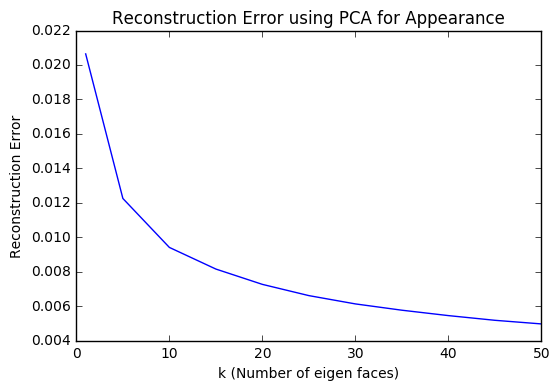

In [96]:
#Plot reconstruction error rate for k = 1, 5, 10, .... 50
plt.plot([1] + [i for i in range(5, 51, 5)], reconst_error)
plt.title('Reconstruction Error using PCA for Appearance')
plt.ylabel('Reconstruction Error')
plt.xlabel('k (Number of eigen faces)')
plt.show()

In [98]:
######PCA Part 2#############

In [100]:
#Read landmarks data
landmarks_data = np.zeros((1000, 68, 2))
landmarks_folder = 'landmarks'
landmark_filenames= []

i = 0
for f in os.listdir(landmarks_folder):
    landmark_filenames.append(f)
    data = sio.loadmat(landmarks_folder + '/' + f)
    landmarks_data[i] = data['lms']
    i += 1

In [101]:
#Split data into train and test
landmarks_train = landmarks_data[0:800, :, :]
landmarks_test = landmarks_data[800:1000, :, :]

In [103]:
#Compute mean and center all the landmark positions
landmark_mean = np.mean(landmarks_train, axis = 0)

landmarks_train_without_mean = np.zeros((800, 68, 2))
for i in range(len(landmarks_train)):
    landmarks_train_without_mean[i] = landmarks_train[i] - landmark_mean

landmarks_test_without_mean = np.zeros((200, 68, 2))
for i in range(len(landmarks_test)):
    landmarks_test_without_mean[i] = landmarks_test[i] - landmark_mean

In [108]:
#Compute the covariance matrix for the train landmarks
landmarks_train_reshaped = landmarks_train_without_mean.reshape(800, 68*2)
landmarks_cov_matrix = np.cov(landmarks_train_reshaped.T)
np.shape(landmarks_cov_matrix)

(136L, 136L)

In [111]:
#Compute the eigen vectors using SVD
landmarks_U, landmarks_S, landmarks_V = np.linalg.svd(landmarks_cov_matrix)

In [112]:
#Find the first ten eigen vectors
landmarks_eigen_vectors_10 = np.zeros((136, 10))
landmarks_eigen_vectors_10 = landmarks_U[:, 0:10]

In [113]:
#Compute the projections of landmarks on eigen vectors
landmarks_test_reshaped = landmarks_test_without_mean.reshape(200, 68*2).T
landmarks_test_reduced = np.dot(landmarks_eigen_vectors_10.T, landmarks_test_reshaped)

In [114]:
#Find the reconstructed landmarks using 10 projections. Add the mean to the reconstructed landmarks
landmarks_test_reconst = np.dot(landmarks_eigen_vectors_10, landmarks_test_reduced)
landmarks_test_reconst_with_mean = np.zeros((200, 68, 2))
for i in range(200):
    landmarks_test_reconst_with_mean[i] = landmarks_test_reconst[:, i:i+1].reshape(68, 2) + landmark_mean

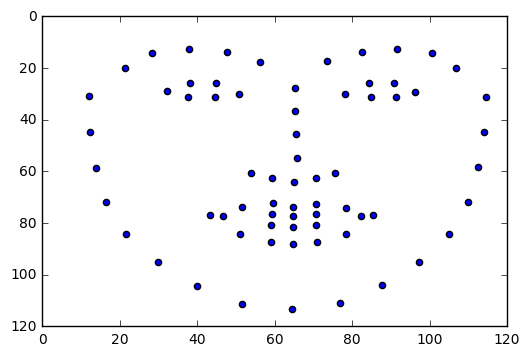

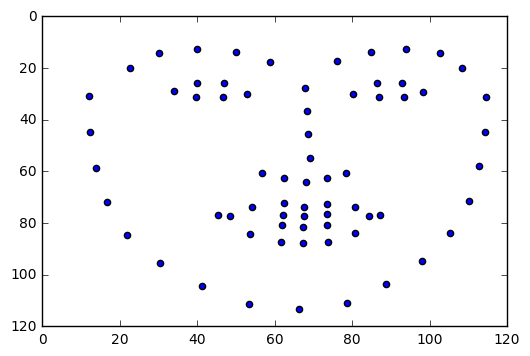

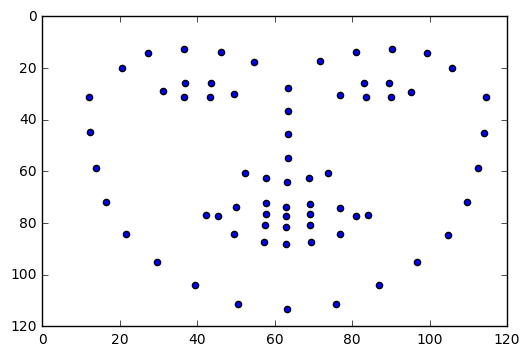

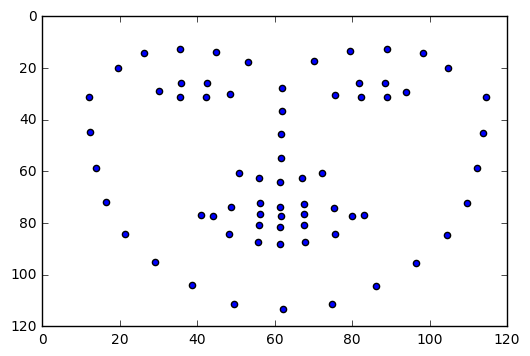

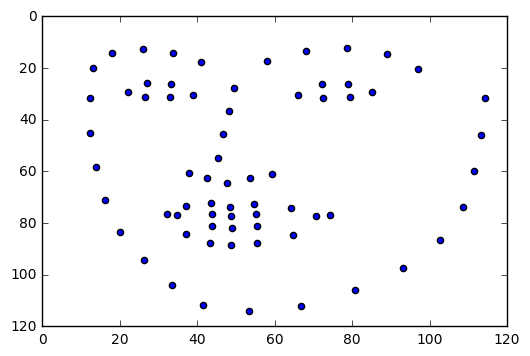

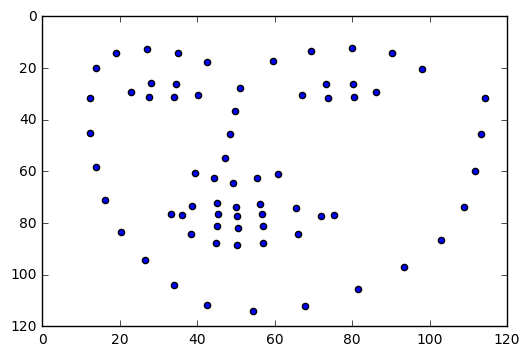

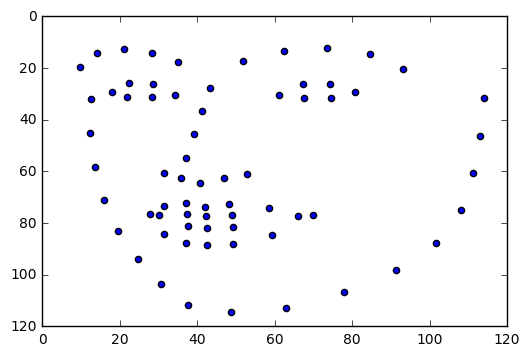

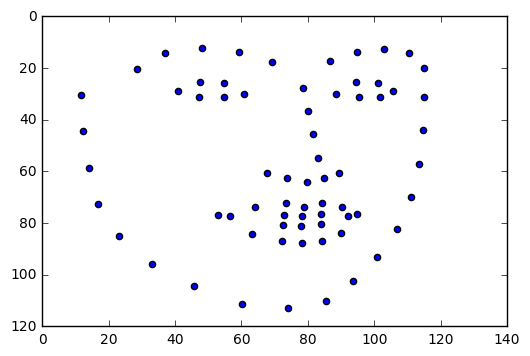

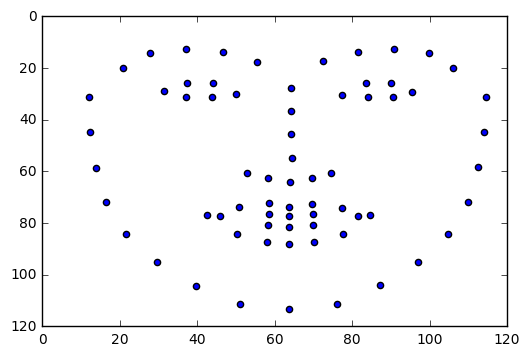

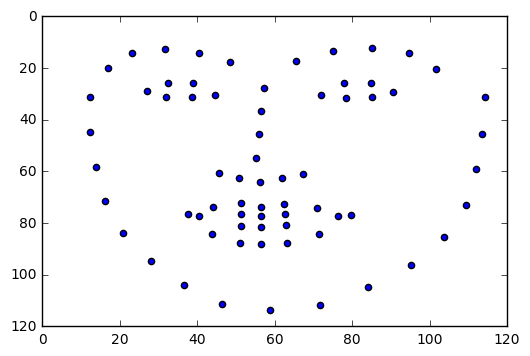

In [327]:
###############Print reconstructed landmarks
for i in range(10):
    plt.scatter(landmarks_test_reconst_with_mean[i, : , 0], landmarks_test_reconst_with_mean[i, :, 1])
    plt.gca().invert_yaxis()
    plt.show()

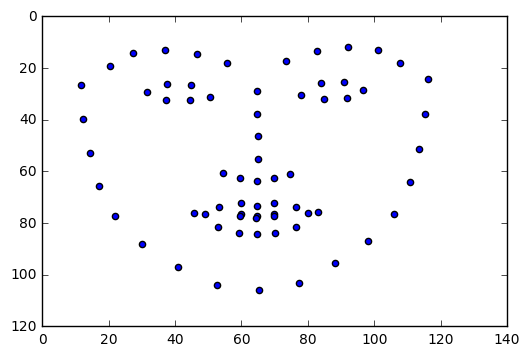

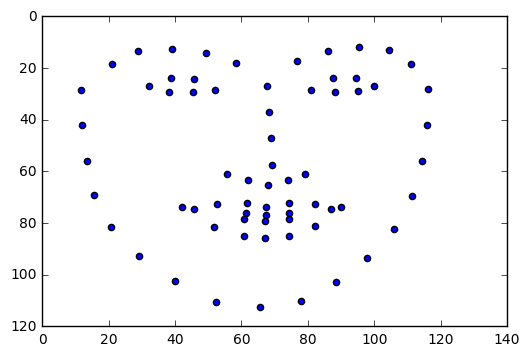

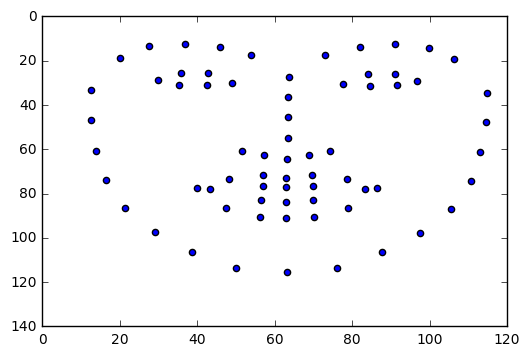

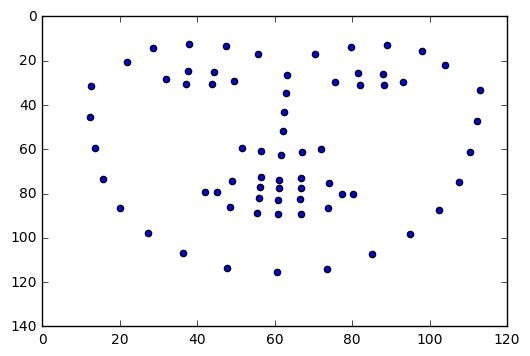

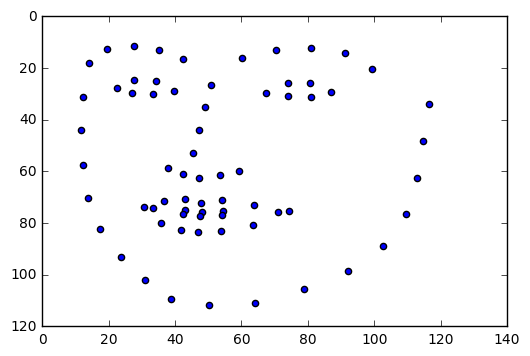

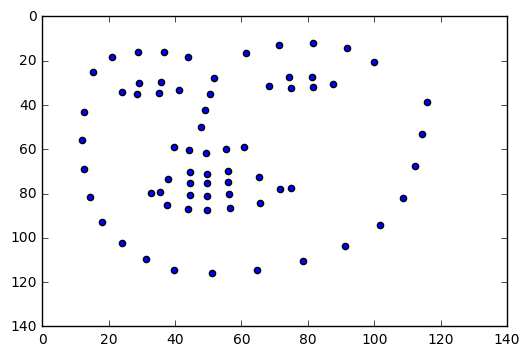

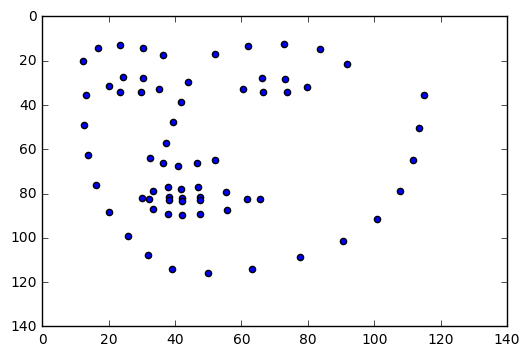

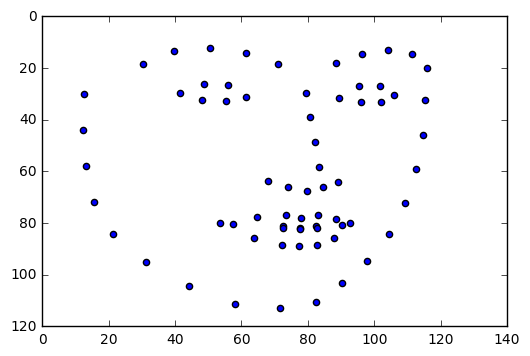

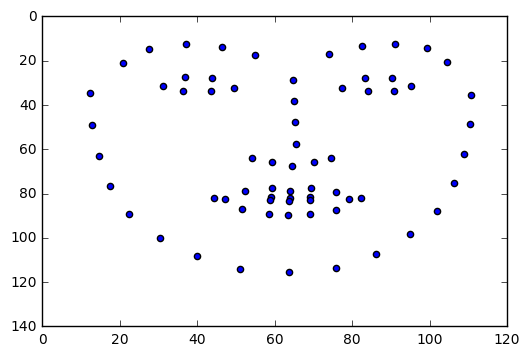

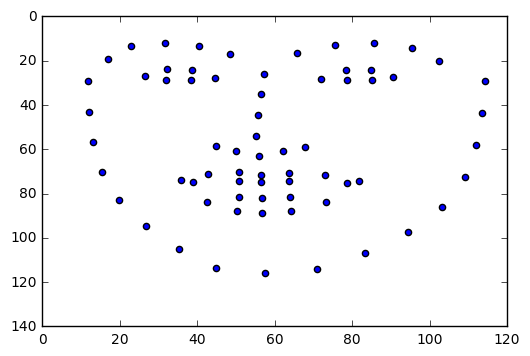

In [328]:
###############Print reconstructed landmarks
for i in range(10):
    plt.scatter(landmarks_test[i, : , 0], landmarks_test[i, :, 1])
    plt.gca().invert_yaxis()
    plt.show()

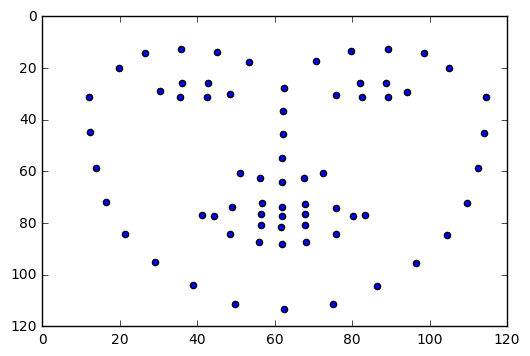

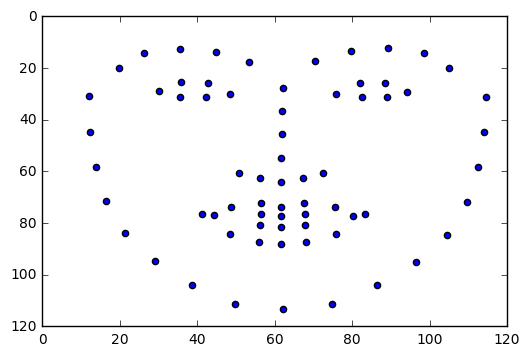

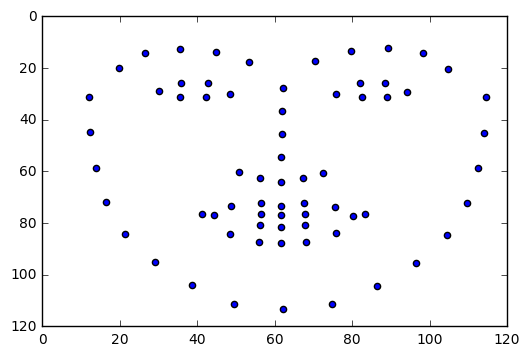

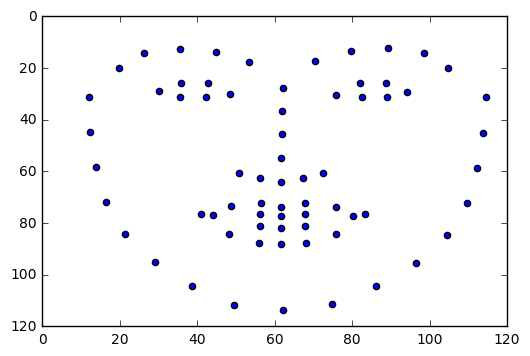

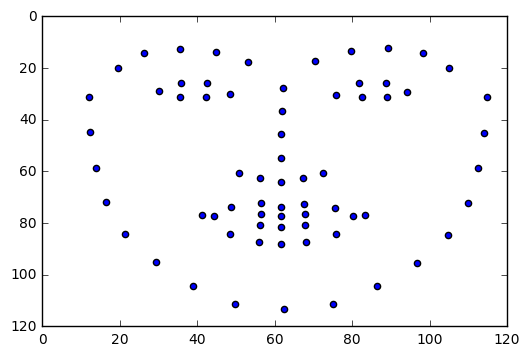

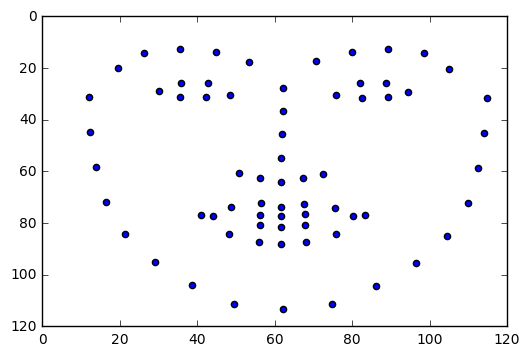

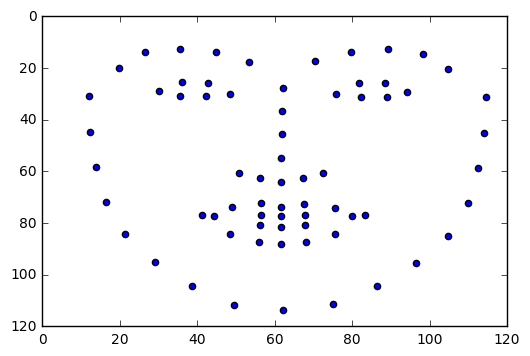

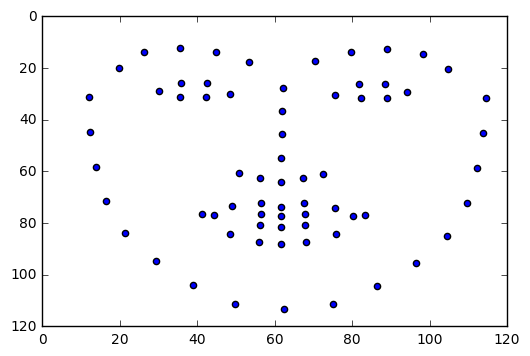

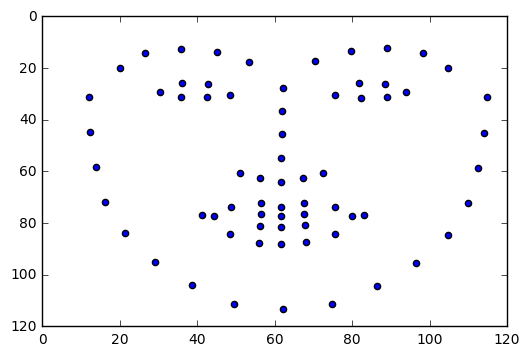

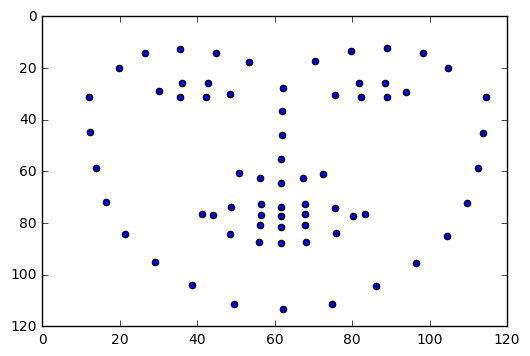

In [122]:
##########PCA 2.i- Plot the first 10 eigen warpings
for i in range(10):
    landmark_eigen_warping = landmarks_eigen_vectors_10[:, i].reshape(68, 2) + landmark_mean
    plt.scatter(landmark_eigen_warping[:, 0], landmark_eigen_warping[:, 1])
    plt.gca().invert_yaxis()
    plt.show()

In [124]:
#Find reconstruction error
landmark_reconstruction_error = np.zeros((11))

j = 1
for k in range(5, 51, 5):
    landmarks_eigen_vectors_k = np.zeros((136, k))
    landmarks_eigen_vectors_k = landmarks_U[:, 0:k]
    landmarks_test_reduced = np.dot(landmarks_eigen_vectors_k.T, landmarks_test_reshaped)
    landmarks_test_reconst = np.dot(landmarks_eigen_vectors_k, landmarks_test_reduced)
    landmarks_test_reconst_with_mean = np.zeros((200, 68, 2))
    for i in range(200):
        landmarks_test_reconst_with_mean[i] = landmarks_test_reconst[:, i:i+1].reshape(68, 2) + landmark_mean
    landmark_sum_of_sq_error = 0.0
    for i in range(200):
        original_landmark = sio.loadmat(landmarks_folder + '/' + landmark_filenames[i + 800])['lms']
        landmark_sum_of_sq_error += np.sum((original_landmark- landmarks_test_reconst_with_mean[i])**2)
    landmark_reconstruction_error[j] = landmark_sum_of_sq_error/(200 * 68)
    j += 1

landmarks_eigen_vectors_k = np.zeros((136, 1))
landmarks_eigen_vectors_k = landmarks_U[:, 0:1]
landmarks_test_reduced = np.dot(landmarks_eigen_vectors_k.T, landmarks_test_reshaped)
landmarks_test_reconst = np.dot(landmarks_eigen_vectors_k, landmarks_test_reduced)
landmarks_test_reconst_with_mean = np.zeros((200, 68, 2))
for i in range(200):
    landmarks_test_reconst_with_mean[i] = landmarks_test_reconst[:, i:i+1].reshape(68, 2) + landmark_mean
landmark_sum_of_sq_error = 0.0
for i in range(200):
    original_landmark = sio.loadmat(landmarks_folder + '/' + landmark_filenames[i + 800])['lms']
    landmark_sum_of_sq_error += np.sum((original_landmark- landmarks_test_reconst_with_mean[i])**2)
landmark_reconstruction_error[0] = landmark_sum_of_sq_error/(200 * 68)

In [125]:
landmark_reconstruction_error

array([1.26676250e+01, 2.31830201e+00, 4.18240298e-01, 1.14723349e-01,
       4.44383898e-02, 1.99477769e-02, 8.36865072e-03, 4.58934378e-03,
       3.10752693e-03, 2.43142415e-03, 1.96485702e-03])

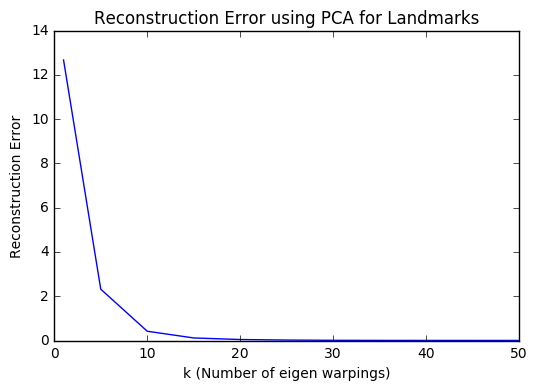

In [127]:
#################PCA Part 2.ii- Plot reconstruction error for landmarks################
plt.plot([1] + [i for i in range(5, 51, 5)], landmark_reconstruction_error)
plt.title('Reconstruction Error using PCA for Landmarks')
plt.ylabel('Reconstruction Error')
plt.xlabel('k (Number of eigen warpings)')
plt.show()

In [128]:
#####PCA Part3: Landmarks and Appearance####

In [164]:
#Read all the files
app_filenames = []
for _file in os.listdir(folder):
    app_filenames.append(_file)
    
app_train = np.zeros((800, 128, 128))
for i in range(800):
    img = cv2.imread(folder + "/" + app_filenames[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    warped_img = mywarper.warp(img, landmarks_train[i], landmark_mean)
    app_train[i] = color.rgb2hsv(warped_img)[:, :, 2]

In [130]:
#Compute the mean img and center the images to the mean
warped_train_mean = np.mean(app_train, axis = 0)

app_train_without_mean = np.zeros((800, 128, 128))
for i in range(len(app_train)):
    app_train_without_mean[i] = app_train[i] - warped_train_mean

In [131]:
#Compute covariance of the input images
app_train_reshaped = app_train_without_mean.reshape(800, 128*128) # each observation / image becomes a row and there are 800 such rows

app_cov_matrix = np.cov(app_train_reshaped.T)

In [132]:
#Compute the eigen vectors
app_U, app_S, app_V = np.linalg.svd(app_cov_matrix)

In [136]:
#####Part i has already been completed in part 2#####

In [84]:
###### Part 3.ii

In [85]:
############ Warp the images to the mean position computed for the train dataset 
#warp(test_img, orig_landmark, mean_postion)

In [137]:
app_test = np.zeros((200, 128, 128))
for i in range(200):
    img = cv2.imread(folder + "/" + app_filenames[i + 800])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    warped_img = mywarper.warp(img, landmarks_test[i], landmark_mean)
    app_test[i] = color.rgb2hsv(warped_img)[:, :, 2]

In [140]:
#Subtract the mean train eigen face (warped) from the test set
app_test_without_mean = np.zeros((200, 128, 128))
for i in range(200):
    app_test_without_mean[i] = app_test[i] - warped_train_mean

In [144]:
######### Project the warped test set to the eigen faces from i
app_test_reshaped = app_test_without_mean.reshape(200, 128*128).T
app_eigen_vectors_50 = app_U[:, 0:50]
app_test_reduced = np.dot(app_eigen_vectors_50.T, app_test_reshaped)

In [146]:
#Reconstruct the appearance from the projections and add the meann value back to it
app_test_reconst = np.dot(app_eigen_vectors_50, app_test_reduced)
app_test_reconst_with_mean = np.zeros((200, 128, 128))
for i in range(200):
    app_test_reconst_with_mean[i] = app_test_reconst[:, i:i+1].reshape(128, 128) + warped_train_mean

In [94]:
#### Part 3.iii

In [175]:
warp_app_test_reconst_with_mean = np.zeros((200, 128, 128, 3))
for i in range(200):
    img = Image.open(folder + "/" + app_filenames[i + 800]) #Read the original test image and use this for H&S layers of reconstructed images
    hsv_img = color.rgb2hsv(img)
    hsv_img[:, :, 2] = app_test_reconst_with_mean[i].clip(min = 0, max = 1)
    reconst_img = color.hsv2rgb(hsv_img)
    warp_app_test_reconst_with_mean[i] = mywarper.warp(reconst_img, landmark_mean, landmarks_test_reconst_with_mean[i]) #Warp images

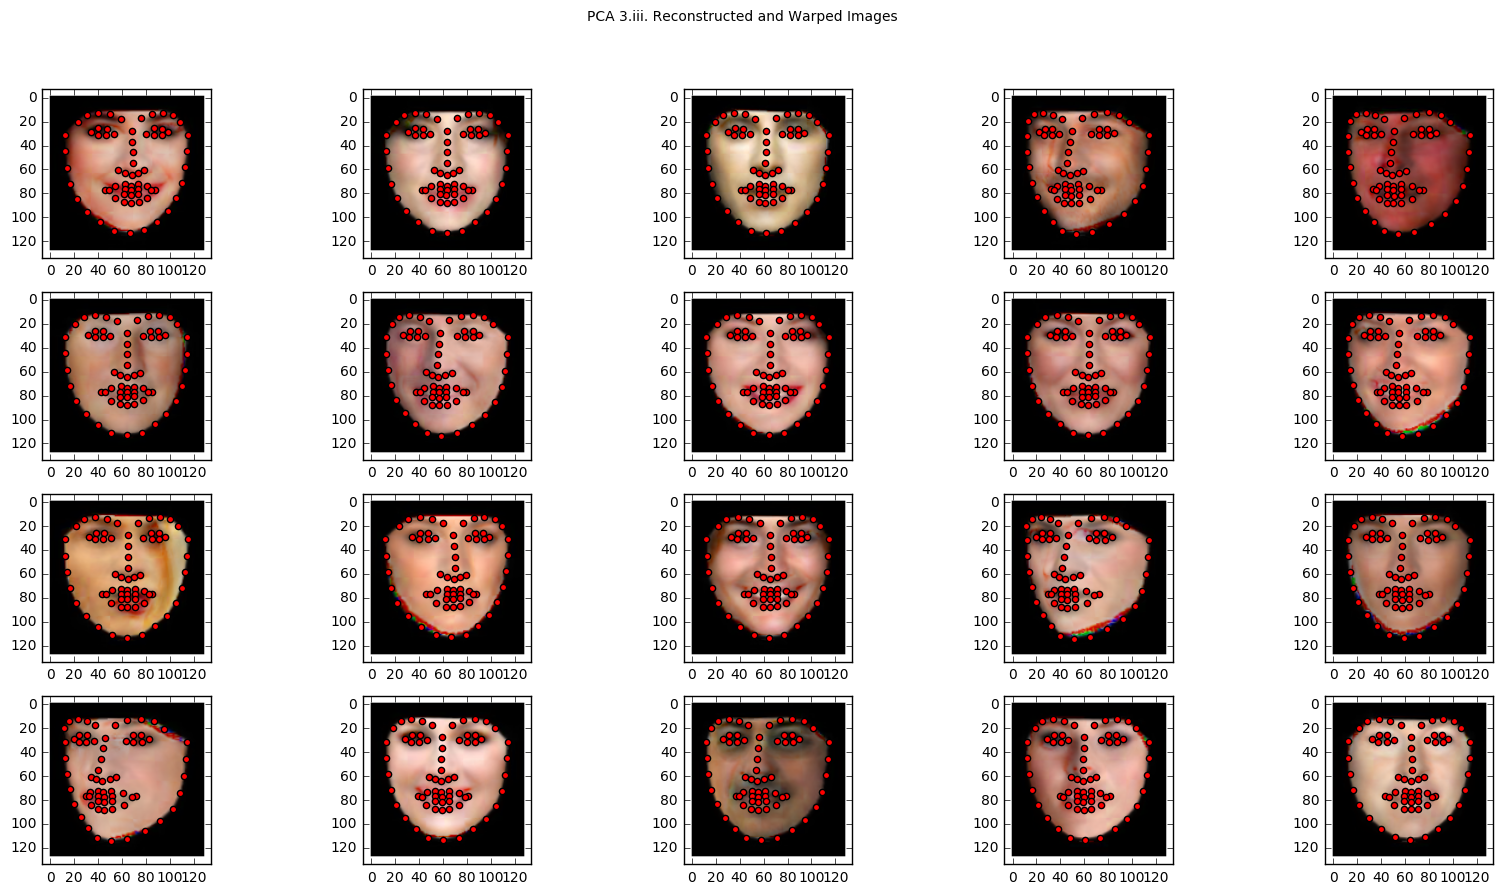

In [200]:
#Display 20 Reconstructed images
f, a = plt.subplots(4, 5, figsize=(20, 10), squeeze = False)
for i in range(5):
    a[0][i].imshow(np.clip(warp_app_test_reconst_with_mean[i + 1], 0, 1))
    a[0][i].scatter(landmarks_test_reconst_with_mean[i + 1][:, 0], landmarks_test_reconst_with_mean[i + 1][:, 1], c = 'r')
    a[1][i].imshow(np.clip(warp_app_test_reconst_with_mean[i + 8], 0, 1))
    a[1][i].scatter(landmarks_test_reconst_with_mean[i + 8][:, 0], landmarks_test_reconst_with_mean[i + 8][:, 1], c = 'r')
    a[2][i].imshow(np.clip(warp_app_test_reconst_with_mean[i + 32], 0, 1))
    a[2][i].scatter(landmarks_test_reconst_with_mean[i + 32][:, 0], landmarks_test_reconst_with_mean[i + 32][:, 1], c = 'r')
    a[3][i].imshow(np.clip(warp_app_test_reconst_with_mean[i + 56], 0, 1))
    a[3][i].scatter(landmarks_test_reconst_with_mean[i + 56][:, 0], landmarks_test_reconst_with_mean[i + 56][:, 1], c = 'r')
f.suptitle('PCA 3.iii. Reconstructed and Warped Images')
plt.show()

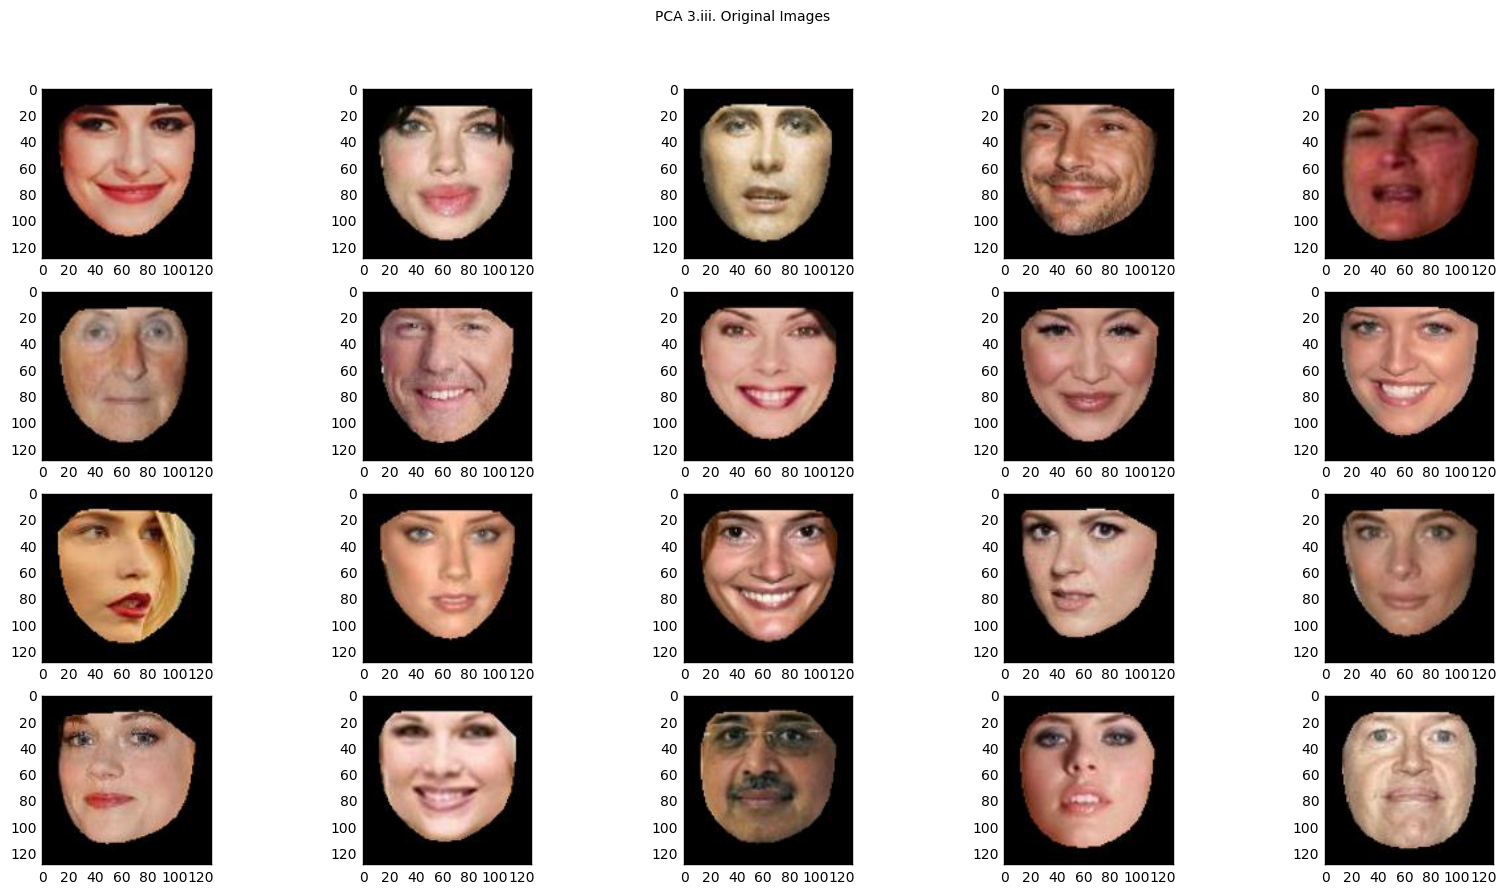

In [326]:
#Display 20 Original images
f, a = plt.subplots(4, 5, figsize=(20, 10), squeeze = False)
for i in range(5):
    a[0][i].imshow(Image.open(folder + "/" + filenames[i + 801]))
    #a[0][i].scatter(landmarks_test[i + 1][:, 0], landmarks_test[i + 1][:, 1], c = 'r')
    a[1][i].imshow(Image.open(folder + "/" + filenames[i + 808]))
    #a[1][i].scatter(landmarks_test[i + 8][:, 0], landmarks_test[i + 8][:, 1], c = 'r')
    a[2][i].imshow(Image.open(folder + "/" + filenames[i + 832]))
    #a[2][i].scatter(landmarks_test[i + 32][:, 0], landmarks_test[i + 32][:, 1], c = 'r')
    a[3][i].imshow(Image.open(folder + "/" + filenames[i + 856]))
    #a[3][i].scatter(landmarks_test[i + 56][:, 0], landmarks_test[i + 56][:, 1], c = 'r')
f.suptitle('PCA 3.iii. Original Images')
plt.show()

In [108]:
#############Plot reconstruction error

In [212]:
app_reconst_error = np.zeros((11))

j = 1
for k in range(5, 51, 5):
    #k_eigen_vectors = get_k_eigen_vectors(k)
    print(k)
    k_eigen_vectors = np.ndarray(shape=(16384, k))
    k_eigen_vectors = app_U[:, 0:k]
    app_test_reduced = np.dot(k_eigen_vectors.T, app_test_reshaped)
    app_test_reconst = np.dot(k_eigen_vectors, app_test_reduced)
    app_test_reconst_with_mean = np.zeros((200, 128, 128))
    for i in range(200):
        app_test_reconst_with_mean[i] = app_test_reconst[:, i:i+1].reshape(128, 128) + warped_train_mean
    sum_of_sq_error = 0
    #warp_app_test_reconst_with_mean = np.zeros((200, 128, 128, 3))
    for i in range(200):
        img = Image.open(folder + "/" + app_filenames[i + 800])
        hsv_img = color.rgb2hsv(img)
        reconst_img = color.rgb2hsv(img)
        reconst_img[:, :, 2] = app_test_reconst_with_mean[i]
        reconst_img = color.hsv2rgb(reconst_img)
        warp_app_test_reconst_with_mean_img = mywarper.warp(reconst_img, landmark_mean, landmarks_test_reconst_with_mean[i])
        reconst_v = color.rgb2hsv(warp_app_test_reconst_with_mean_img)[:, :, 2]
        sum_of_sq_error += np.sum((reconst_v - hsv_img[:, :, 2]) ** 2)
    #sum_of_sq_error =
    app_reconst_error[j] =  sum_of_sq_error / (200 * 128 * 128)
    j+=1
    
k = 1
k_eigen_vectors = np.ndarray(shape=(16384, k))
k_eigen_vectors = app_U[:, 0:k]
app_test_reduced = np.dot(k_eigen_vectors.T, app_test_reshaped)
app_test_reconst = np.dot(k_eigen_vectors, app_test_reduced)
app_test_reconst_with_mean = np.zeros((200, 128, 128))
for i in range(200):
    app_test_reconst_with_mean[i] = app_test_reconst[:, i:i+1].reshape(128, 128) + warped_train_mean
sum_of_sq_error = 0
for i in range(200):
    img = Image.open(folder + "/" + app_filenames[i + 800])
    hsv_img = color.rgb2hsv(img)
    reconst_img = color.rgb2hsv(img)
    reconst_img[:, :, 2] = app_test_reconst_with_mean[i]
    reconst_img = color.hsv2rgb(reconst_img)
    warp_app_test_reconst_with_mean_img = mywarper.warp(reconst_img, landmark_mean, landmarks_test_reconst_with_mean[i])
    reconst_v = color.rgb2hsv(warp_app_test_reconst_with_mean_img)[:, :, 2]
    sum_of_sq_error += np.sum((reconst_v - hsv_img[:, :, 2]) ** 2)
#sum_of_sq_error =
app_reconst_error[0] =  sum_of_sq_error / (200 * 128 * 128)

5
10
15
20
25
30
35
40
45
50


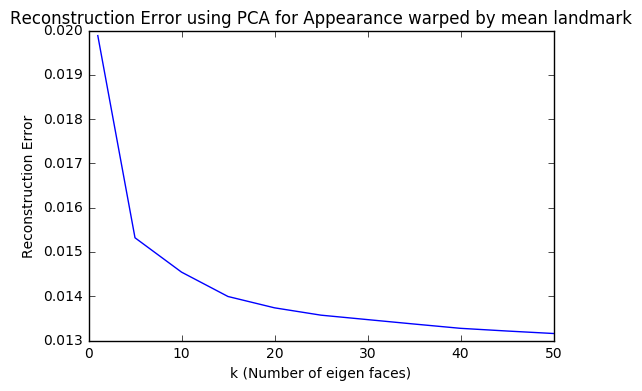

In [215]:
plt.plot([1] + [i for i in range(5, 51, 5)], app_reconst_error)
plt.title('Reconstruction Error using PCA for Appearance warped by mean landmark')
plt.ylabel('Reconstruction Error')
plt.xlabel('k (Number of eigen faces)')
plt.show()

In [125]:
################### Part 4

In [236]:
#Sample landmark projections from the normal distribution N(0, rt(lambda))
synth_landmarks_projection = np.zeros((50, 10))
for i in range(50):
    for j in range(10):
        synth_landmarks_projection[i, j] = np.random.normal(0, math.sqrt(landmarks_S[j]))

In [237]:
#Reconstruction of landmarks from the projections sampled above
synth_landmarks_reconst = np.dot(landmarks_eigen_vectors_10, synth_landmarks_projection.T)
#np.shape(synth_landmarks_reconst)

In [248]:
synth_landmarks_with_mean = np.zeros((50, 68, 2))
for i in range(50):
    synth_landmarks_with_mean[i] = synth_landmarks_reconst[:, i].reshape(68, 2) +landmark_mean

#synth_landmarks_with_mean = synth_landmarks_reconst.T.reshape(50, 68, 2) 
np.shape(synth_landmarks_with_mean)

(50L, 68L, 2L)

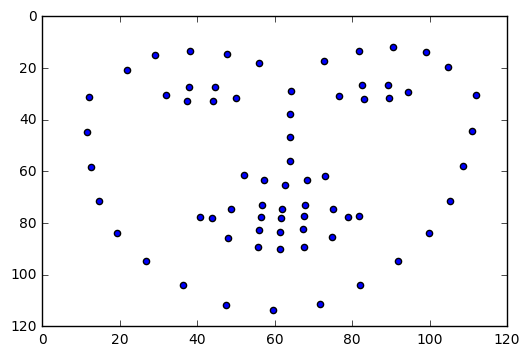

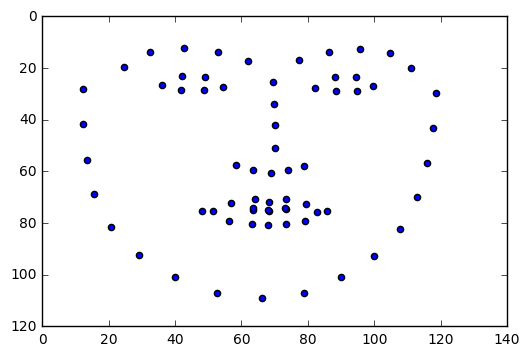

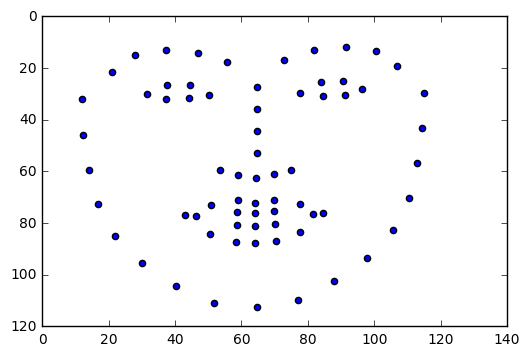

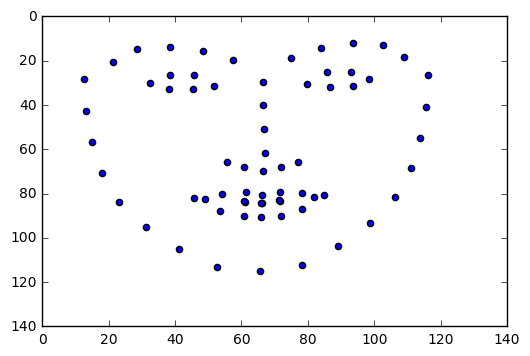

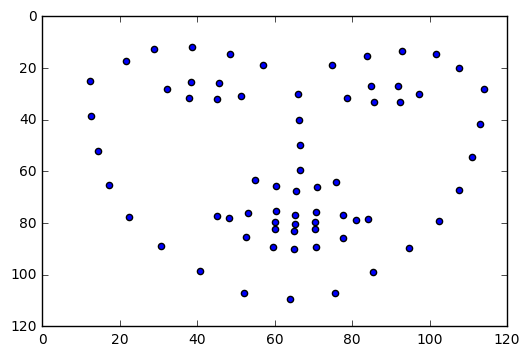

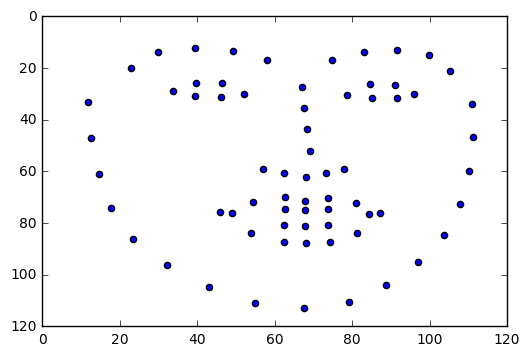

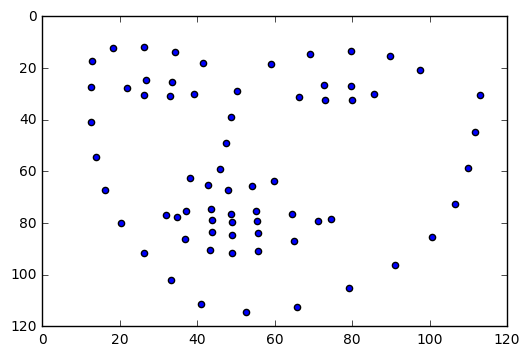

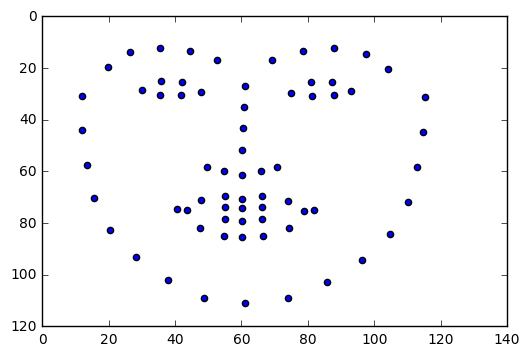

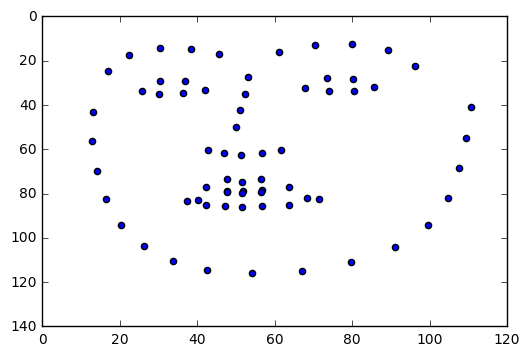

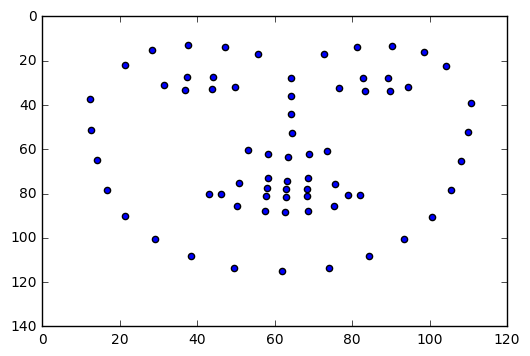

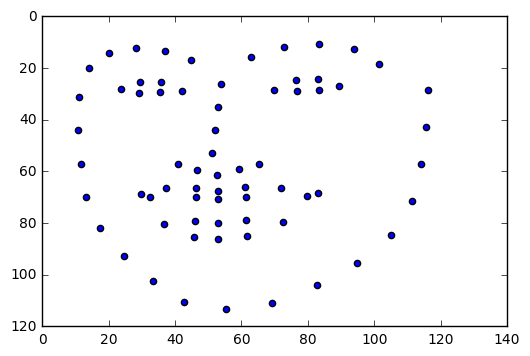

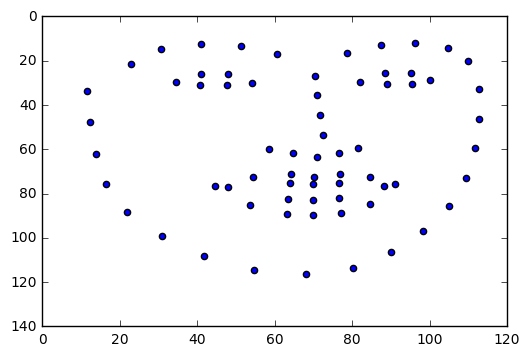

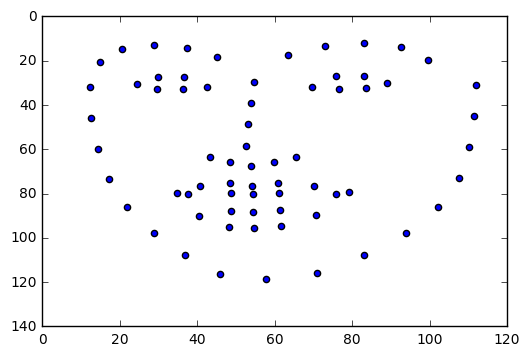

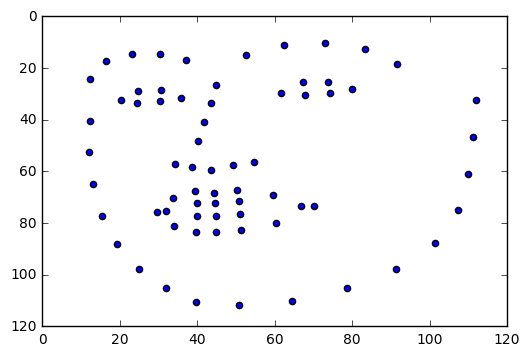

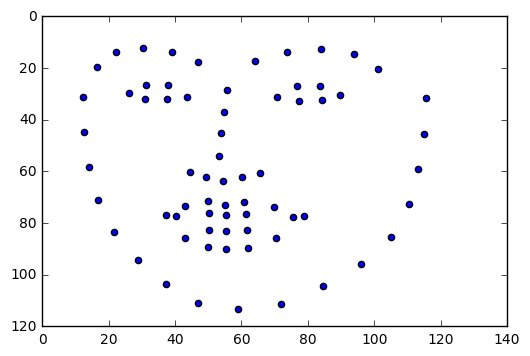

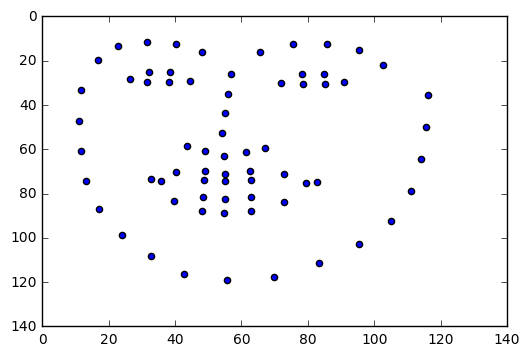

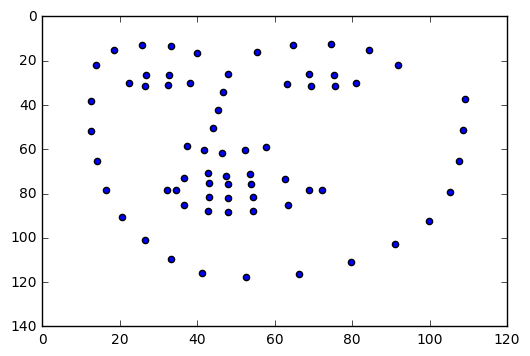

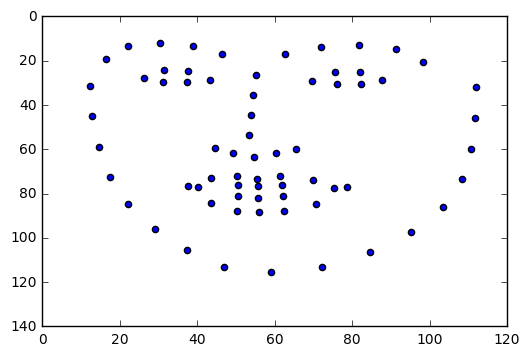

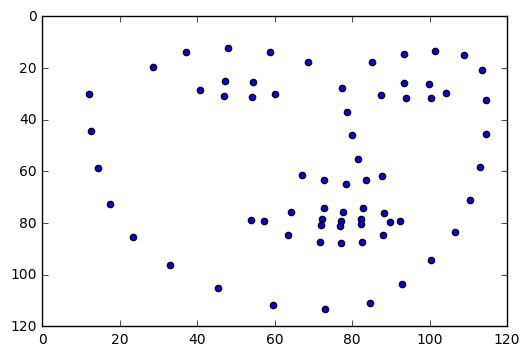

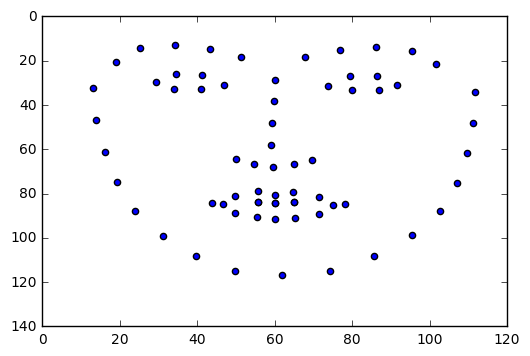

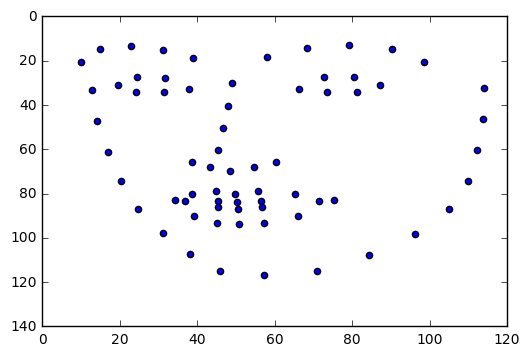

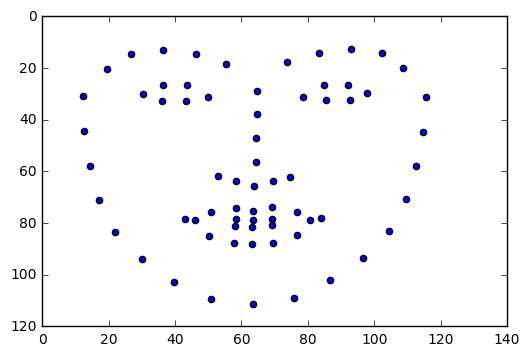

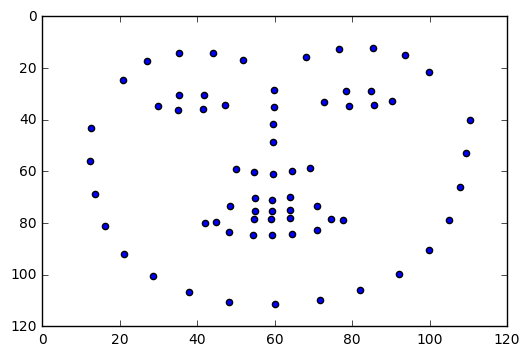

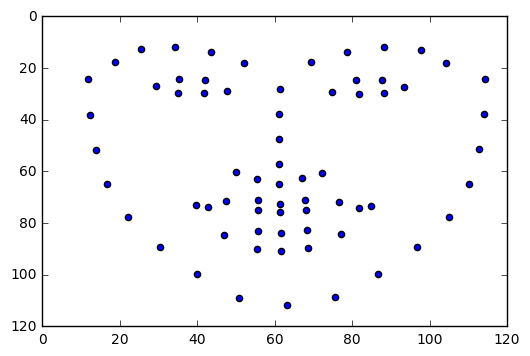

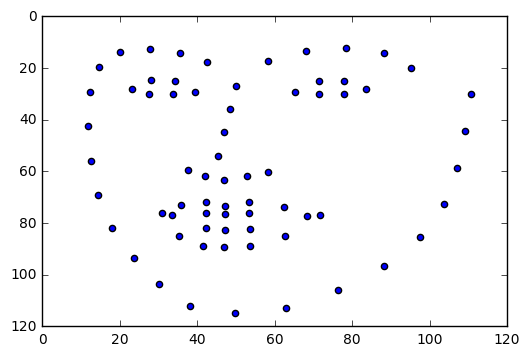

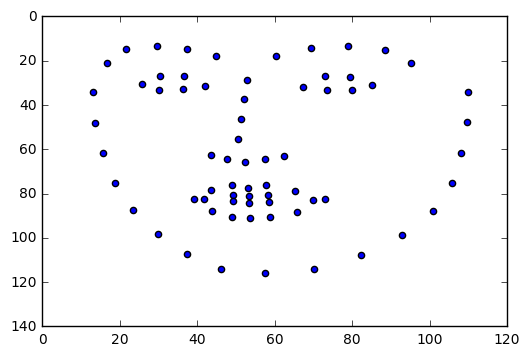

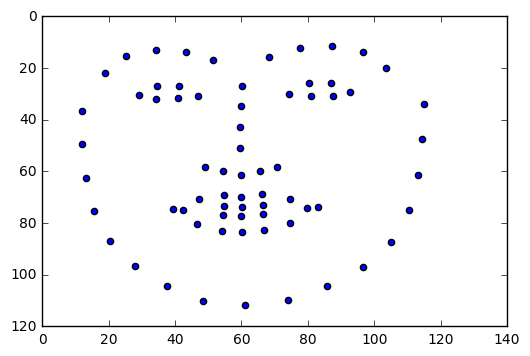

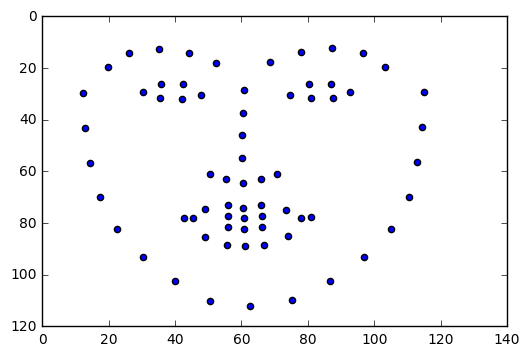

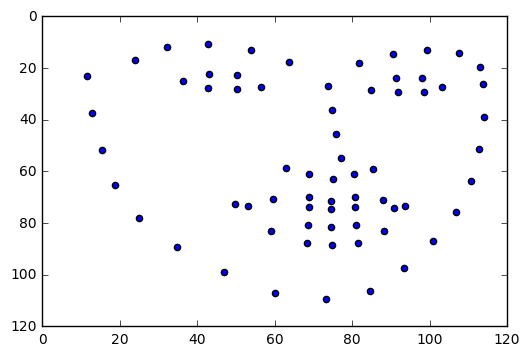

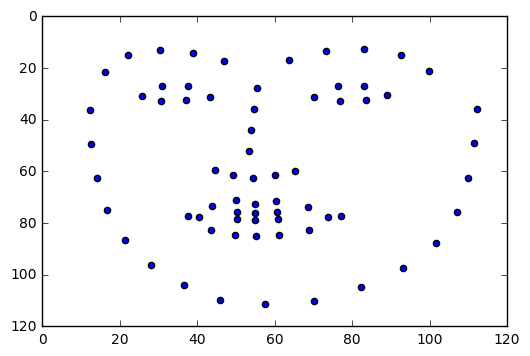

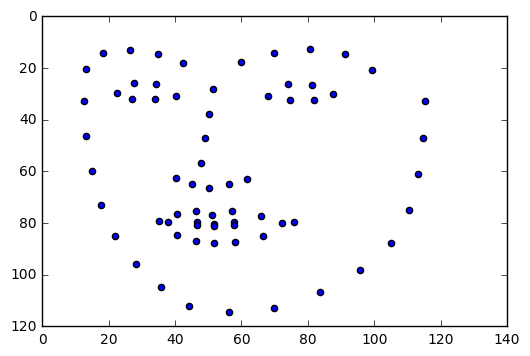

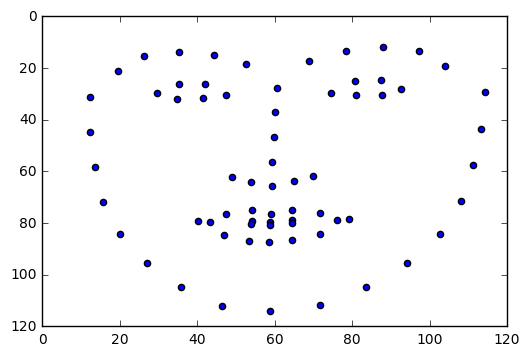

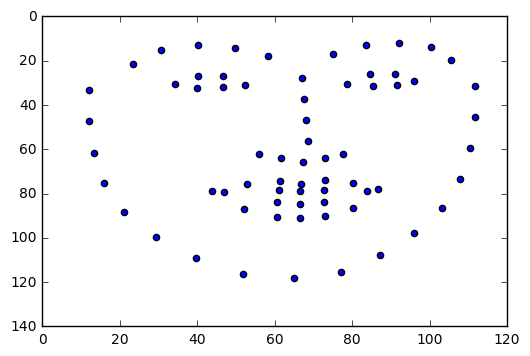

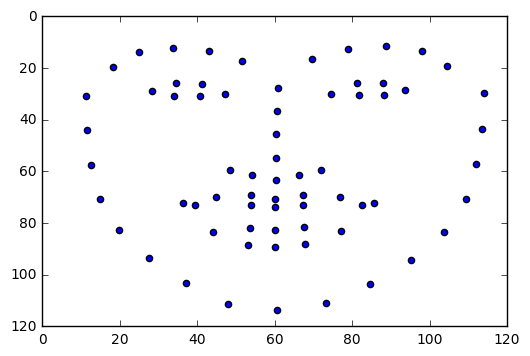

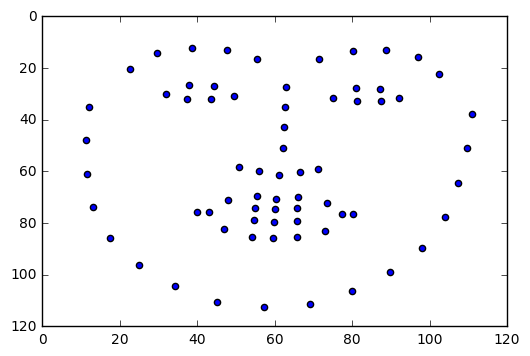

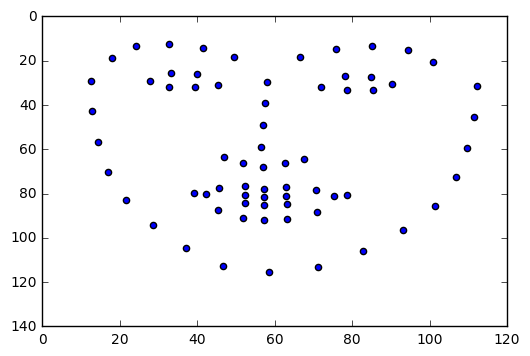

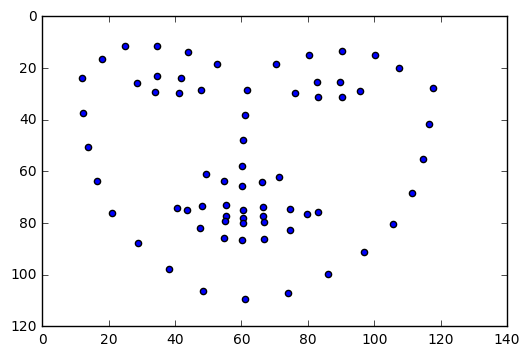

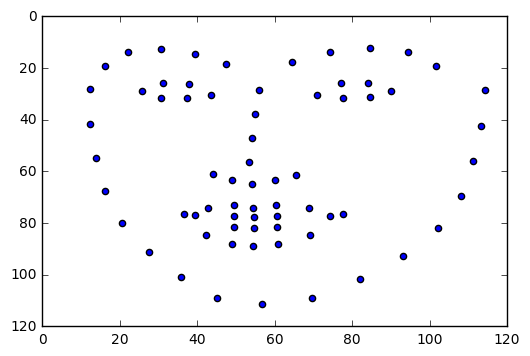

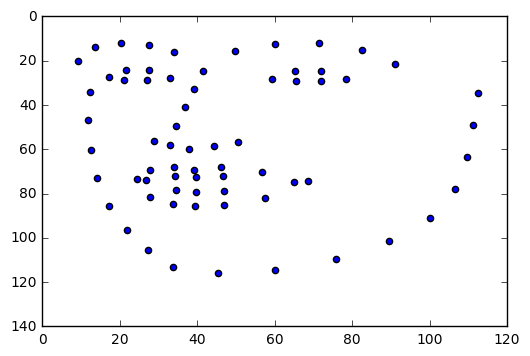

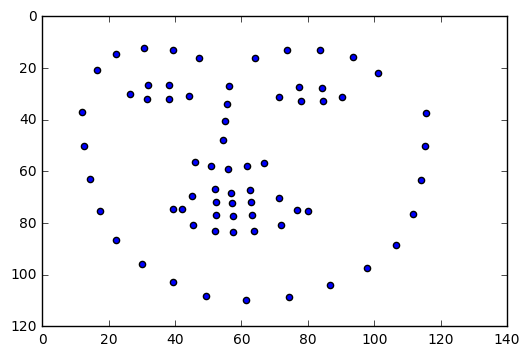

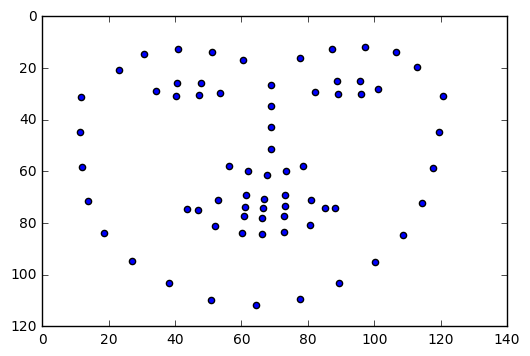

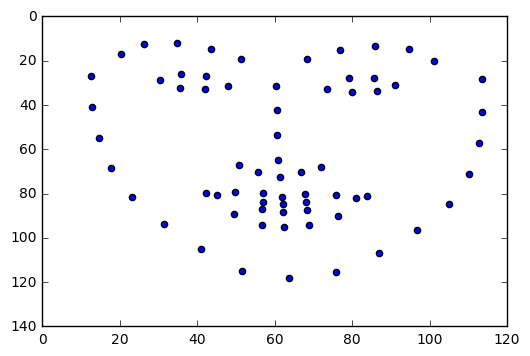

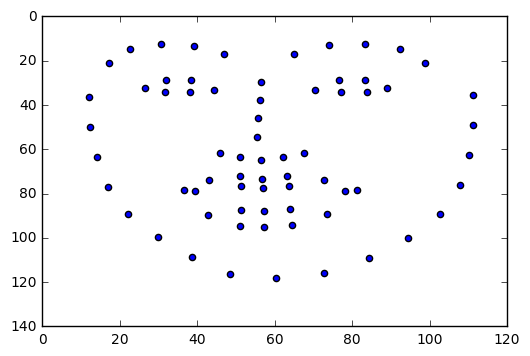

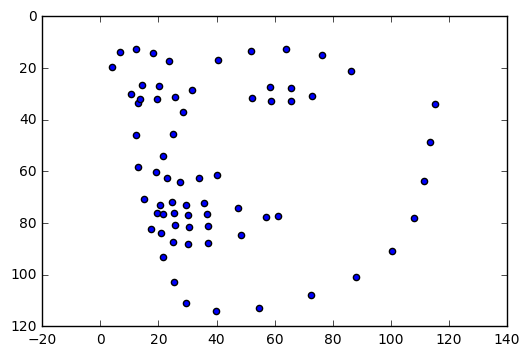

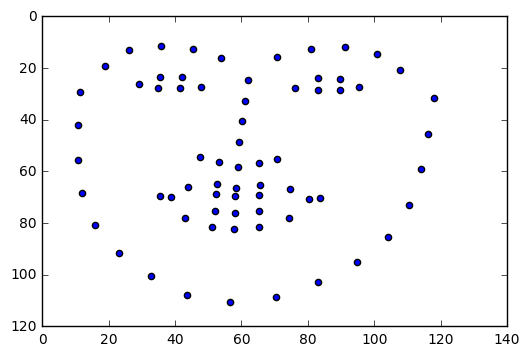

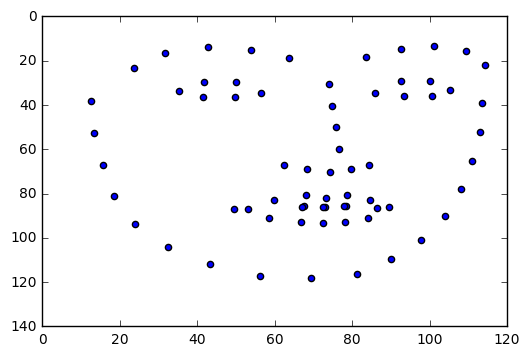

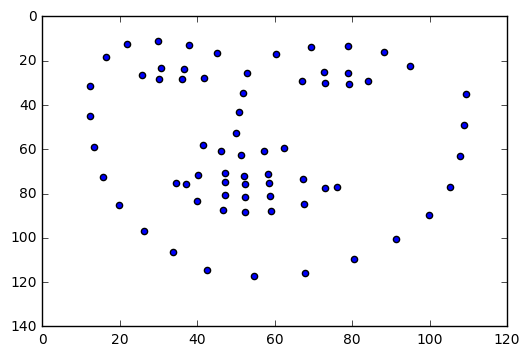

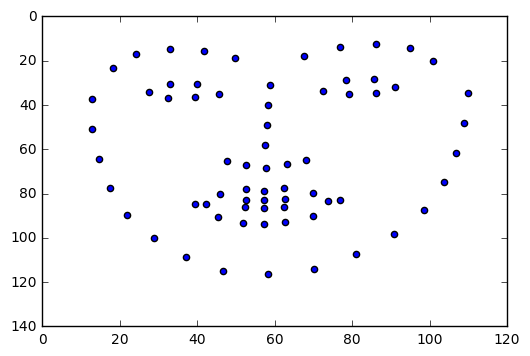

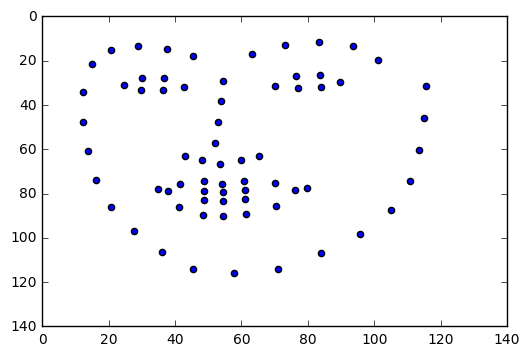

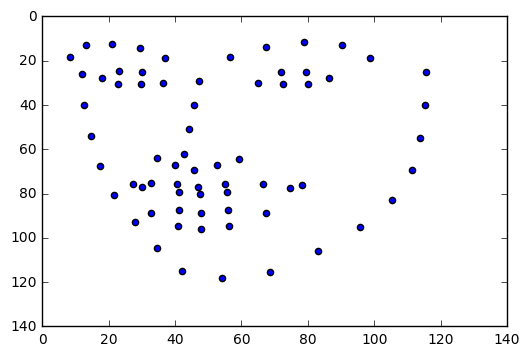

In [268]:
#Plot the landmarks
for i in range(50):
    plt.scatter(synth_landmarks_with_mean[i, :, 0], synth_landmarks_with_mean[i, :, 1])
    #plt.scatter(synth_landmarks_reconst.reshape(68, 2)[:, 0], synth_landmarks_reconst.reshape(68, 2)[:, 1])
    plt.gca().invert_yaxis()
    plt.show()

In [238]:
#Sample appearance projections from the normal distribution N(0, rt(lambda))
synth_app_projection = np.zeros((50, 50))
for i in range(50):
    for j in range(50):
        synth_app_projection[i, j] = np.random.normal(0, math.sqrt(app_S[j]))

In [240]:
#Reconstruction of appearance from the projections sampled above
synth_app_reconst = np.dot(app_eigen_vectors_50, synth_app_projection.T)

In [244]:
synth_app_reconst_with_mean = np.zeros((50, 128, 128))
for i in range(50):
    synth_app_reconst_with_mean[i] = synth_app_reconst[:, i].reshape(128, 128) + warped_train_mean

In [ ]:
f, a = plt.subplots(4, 5, figsize=(20, 10), squeeze = False)
for i in range(5):
    a[0][i].imshow(Image.open(folder + "/" + filenames[i + 801]))
    a[0][i].scatter(landmarks_test[i + 1][:, 0], landmarks_test[i + 1][:, 1], c = 'r')
    a[1][i].imshow(Image.open(folder + "/" + filenames[i + 808]))
    a[1][i].scatter(landmarks_test[i + 8][:, 0], landmarks_test[i + 8][:, 1], c = 'r')
    a[2][i].imshow(Image.open(folder + "/" + filenames[i + 832]))
    a[2][i].scatter(landmarks_test[i + 32][:, 0], landmarks_test[i + 32][:, 1], c = 'r')
    a[3][i].imshow(Image.open(folder + "/" + filenames[i + 856]))
    a[3][i].scatter(landmarks_test[i + 56][:, 0], landmarks_test[i + 56][:, 1], c = 'r')
f.suptitle('PCA 3.iii. Original Images')
plt.show()

In [245]:
synth_warped = np.zeros((50, 128, 128, 1))
for i in range(50):
    img = synth_app_reconst_with_mean[i].reshape(128, 128, 1)
    synth_warped[i] = mywarper.warp(img, landmark_mean, synth_landmarks_reconst[:, i].reshape(68, 2) +landmark_mean)

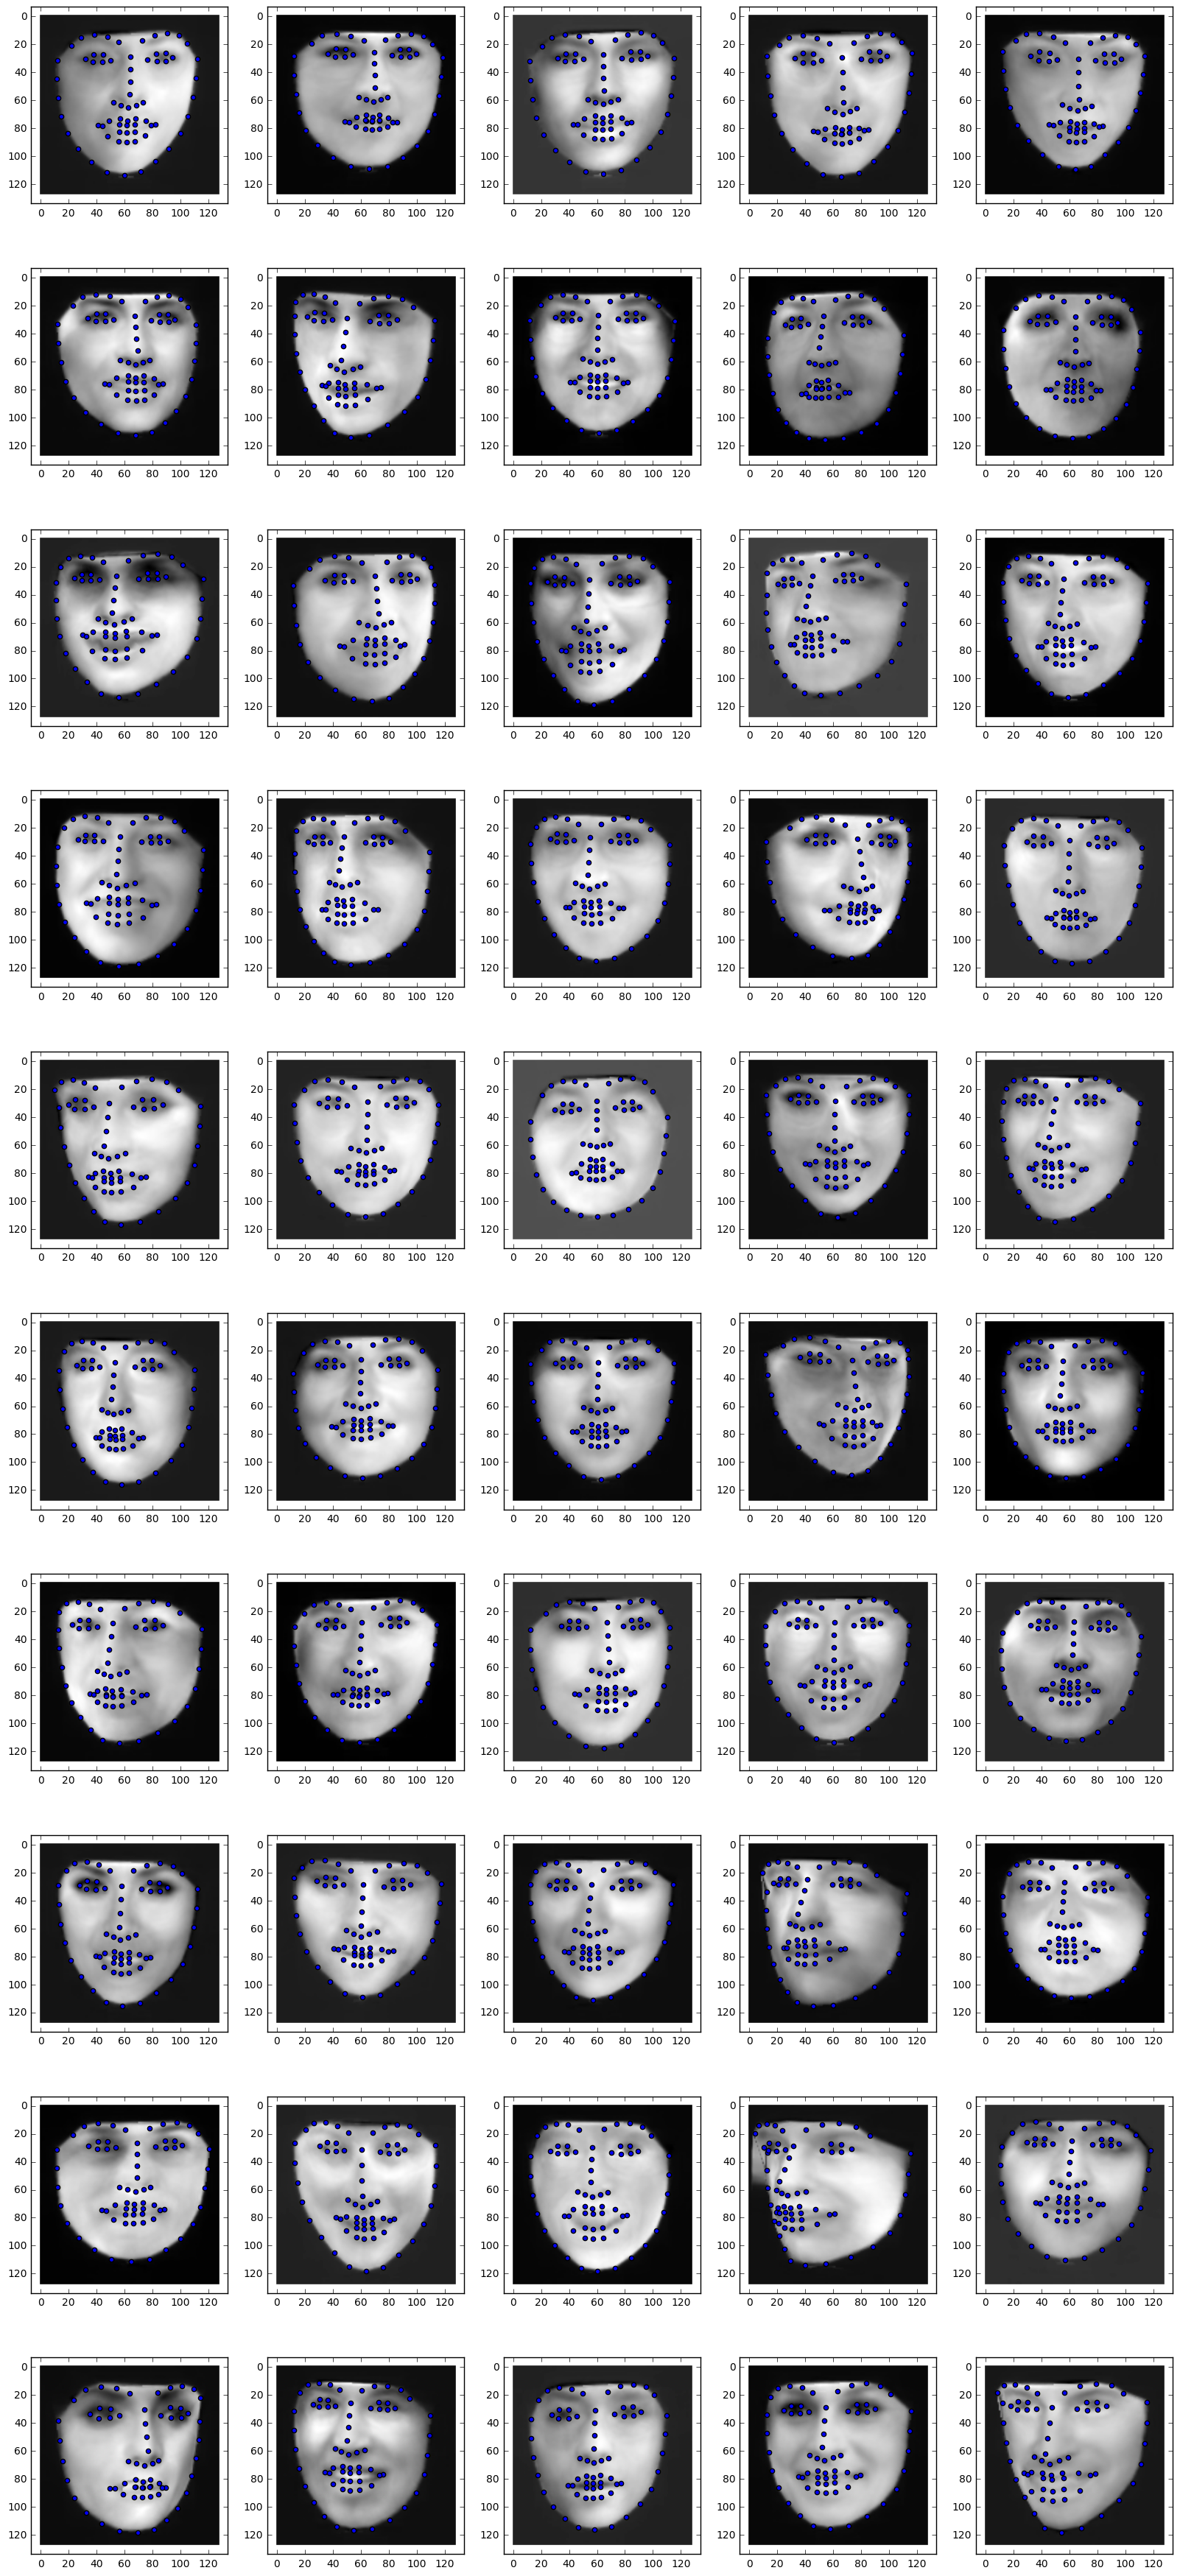

In [267]:
f, a = plt.subplots(10, 5, figsize=(20, 45), squeeze = False)
for i in range(10):
    for j in range(5):
        a[i][j].imshow(synth_warped[i * 5 + j].reshape(128, 128), cmap="gray")
        a[i][j].scatter(synth_landmarks_with_mean[i * 5 + j, : , 0], synth_landmarks_with_mean[i * 5 + j, : , 1])
plt.show()    

In [269]:
######################Fisher Linear Discriminant###########################

In [270]:
###### Part 1

In [271]:
###### Find the reduced, warped training image set for training of FLD

In [272]:
male_img_folder = 'male_images'
female_img_folder = 'female_images'
male_landmarks_folder = 'male_landmarks'
female_landmarks_foder = 'female_landmarks'

In [273]:
#### Find filenames that are females######
y = [0] * 1000
female_filenames = []
for _file in os.listdir(female_img_folder):
    female_filenames.append(_file)

In [274]:
for i in range(len(app_filenames)):
    if app_filenames[i] in female_filenames:
        y[i] = 1

In [205]:
##### Find mean for class 0- males######
#####The indices in y which are 0 are the male images#####

In [211]:
#y[0:800].count(0)

335

In [212]:
#y[0:800].count(1)

465

In [275]:
#### Reduce dimension of warped images
app_train_reduced = np.dot(app_eigen_vectors_50.T, app_train_reshaped.T)

In [276]:
##### Reduce dimension of landmarks
landmark_train_reduced = np.dot(landmarks_eigen_vectors_10.T, landmarks_train_reshaped.T)

In [277]:
fld_input = np.vstack((app_train_reduced, landmark_train_reduced))
fld_input = fld_input.T

In [242]:
#Compute mean of the input

In [278]:
dim1 = y[0:800].count(0)
dim2 = y[0:800].count(1)
fld_input_male = np.zeros((dim1, 60))
fld_input_female = np.zeros((dim2, 60))
j = 0
k = 0
for i in range(800):
    if y[i] == 0:
        fld_input_male[j] = fld_input[i]
        j += 1
    else:
        fld_input_female[k] = fld_input[i]
        k += 1

In [279]:
fld_input_male_mean = np.mean(fld_input_male, axis = 0)
fld_input_female_mean = np.mean(fld_input_female, axis = 0)

In [280]:
############Find inverse of Sw
###########Sw = S1 + S2

In [281]:
#Calculate S1 = Sum((x-m)(x-m)T)

In [282]:
##### Subtract mean from the images
fld_input_male_wo_mean = fld_input_male - fld_input_male_mean
fld_input_female_wo_mean = fld_input_female - fld_input_female_mean

In [283]:
S1 = np.dot(fld_input_male_wo_mean.T, fld_input_male_wo_mean)
S2 = np.dot(fld_input_female_wo_mean.T, fld_input_female_wo_mean)
Sw = S1 + S2
Sw_inverse = np.linalg.inv(Sw)

In [284]:
w = np.dot(Sw_inverse, (fld_input_male_mean - fld_input_female_mean))
np.shape(w)

(60L,)

In [285]:
#####Thresold calculation
c = np.dot(w.reshape(1, 60), (0.5)* (fld_input_male_mean + fld_input_female_mean).reshape(60, 1))
print(c)

[[0.00134376]]


In [269]:
############# Testing

In [292]:
landmarks_test_reduced = np.dot(landmarks_eigen_vectors_10.T, landmarks_test_reshaped)
app_test_reduced = np.dot(app_eigen_vectors_50.T, app_test_reshaped)

In [293]:
#Create test of dime 60*1
fld_test = np.vstack((app_test_reduced, landmarks_test_reduced))

In [295]:
fld_output = np.dot(w.T, fld_test)
fld_output = (fld_output < c).astype(int)

In [296]:
#####Error rate of classification

In [302]:
error = np.count_nonzero(fld_output - y[800:1000])
error

12

In [303]:
#################Part 2

In [304]:
#####Appearance on Fisher face

In [305]:
dim1 = y[0:800].count(0)
dim2 = y[0:800].count(1)
fld_app_male = np.zeros((dim1, 50))
fld_app_female = np.zeros((dim2, 50))
j = 0
k = 0
for i in range(800):
    if y[i] == 0:
        fld_app_male[j] = app_train_reduced.T[i]
        j += 1
    else:
        fld_app_female[k] = app_train_reduced.T[i]
        k += 1

In [306]:
#Find the mean
fld_app_male_mean = np.mean(fld_app_male, axis = 0)
fld_app_female_mean = np.mean(fld_app_female, axis = 0)

In [307]:
##### Subtract mean from the images
fld_app_male_wo_mean = fld_app_male - fld_app_male_mean
fld_app_female_wo_mean = fld_app_female - fld_app_female_mean

In [308]:
App_S1 = np.dot(fld_app_male_wo_mean.T, fld_app_male_wo_mean)
App_S2 = np.dot(fld_app_female_wo_mean.T, fld_app_female_wo_mean)

In [309]:
App_Sw = App_S1 + App_S2
App_Sw_inverse = np.linalg.inv(App_Sw)
App_w = np.dot(App_Sw_inverse, (fld_app_male_mean - fld_app_female_mean))

In [310]:
App_c = np.dot(App_w.reshape(1, 50), (0.5)* (fld_app_male_mean + fld_app_female_mean).reshape(50, 1))

In [329]:
App_c

array([[0.00119649]])

In [312]:
#####Landmarks on Fisher face

In [313]:
dim1 = y[0:800].count(0)
dim2 = y[0:800].count(1)
fld_landmark_male = np.zeros((dim1, 10))
fld_landmark_female = np.zeros((dim2, 10))
j = 0
k = 0
for i in range(800):
    if y[i] == 0:
        fld_landmark_male[j] = landmark_train_reduced.T[i]
        j += 1
    else:
        fld_landmark_female[k] = landmark_train_reduced.T[i]
        k += 1

In [315]:
#Find the mean
fld_landmark_male_mean = np.mean(fld_landmark_male, axis = 0)
fld_landmark_female_mean = np.mean(fld_landmark_female, axis = 0)

In [316]:
##### Subtract mean from the images
fld_landmark_male_wo_mean = fld_landmark_male - fld_landmark_male_mean
fld_landmark_female_wo_mean = fld_landmark_female - fld_landmark_female_mean

In [317]:
Landmark_S1 = np.dot(fld_landmark_male_wo_mean.T, fld_landmark_male_wo_mean)
Landmark_S2 = np.dot(fld_landmark_female_wo_mean.T, fld_landmark_female_wo_mean)

In [318]:
Landmark_Sw = Landmark_S1 + Landmark_S2
Landmark_Sw_inverse = np.linalg.inv(Landmark_Sw)
Landmark_w = np.dot(Landmark_Sw_inverse, (fld_landmark_male_mean - fld_landmark_female_mean))

In [322]:
Landmark_c = np.dot(Landmark_w.reshape(1, 10), (0.5)* (fld_landmark_male_mean + fld_landmark_female_mean).reshape(10, 1))
Landmark_c

array([[0.00014156]])

In [321]:
#app_test_reduced, landmarks_test_reduced
fld_app_output = np.dot(App_w.T, app_test_reduced)
fld_landmark_output = np.dot(Landmark_w.T, landmarks_test_reduced)

In [323]:
point_color = ['g'] * 200
for i in range(200):
    if y[i + 800] == 0:
        point_color[i] = 'b'

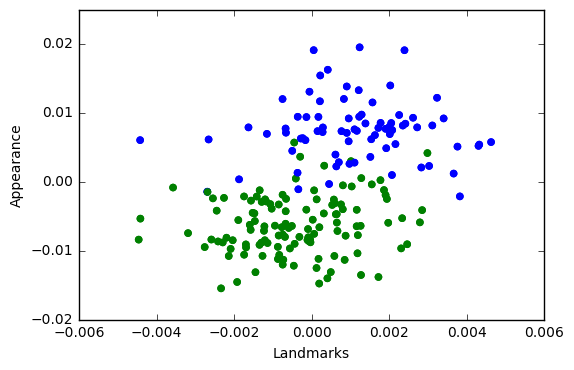

In [325]:
plt.scatter(fld_landmark_output.T, fld_app_output.T, color = point_color)
plt.axis([-0.006, 0.006, -0.02, 0.025])
plt.xlabel('Landmarks')
plt.ylabel('Appearance')
plt.show()